## Release notes

In [40]:
pwd

'/home/ml/Jupyter_root/123/CV using numpy'

- v4 
- Optimizer
'''Update velocity using momentum and gradient
velocity[i] = momentum * velocity[i] - lr * grad          
Update parameter using new velocity
param += velocity[i]
Change to 
np.add(momentum * velocity[i], -lr * grad, out=velocity[i])
- v3
- add SGD with momentum
- v2
- Cleaned codes
- vq
-  Make all classes and compare them

# Lib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
import random

# CFG

In [2]:
np.random.seed(42)
random.seed(42)

In [3]:
class CFG:
    batch = 256
    shuffle = True
    num_classes = 10
    learning_rate = 0.01
    epoch=100

# Read data

In [4]:
# Load the dataset using NumPy
# Load train data
train_data = np.loadtxt('train.csv', delimiter=',', skiprows=1)
train_labels = train_data[:, 0]  # Labels 0 and 1
train_data = train_data[:, 1:]   # Pixels

## Checking

In [5]:
train_labels

array([1., 0., 1., ..., 7., 6., 9.])

In [6]:
np.unique(train_labels) # from 0 to 9

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [7]:
train_data.shape

(42000, 784)

## Plot 

In [8]:
train_data = np.reshape(train_data, (train_data.shape[0],28,28,1)).copy()/255

In [9]:
train_data.shape

(42000, 28, 28, 1)

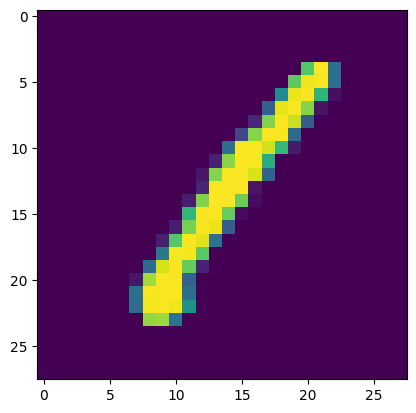

In [10]:
plt.imshow(train_data[0])

In [11]:
train_data = np.einsum('bhwc ->bchw',train_data)

In [12]:
train_data = train_data.reshape(-1,28*28)

In [13]:
class CustomDataLoader:
    def __init__(self, data, targets, batch_size, shuffle=True):
        self.data = data
        self.targets = targets
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_samples = len(self.data)
        self.indices = np.arange(self.num_samples)
        
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __iter__(self):
        for start_idx in range(0, self.num_samples, self.batch_size):
            batch_indices = self.indices[start_idx:start_idx + self.batch_size]
            batch_data = self.data[batch_indices]
            batch_targets = self.targets[batch_indices]
            yield batch_data, batch_targets
    
    def __len__(self):
        return len(self.indices)

In [14]:
trainloader = CustomDataLoader(train_data[:10000].copy(), train_labels[:10000].copy(), CFG.batch, shuffle=CFG.shuffle)
testloader = CustomDataLoader(train_data[10001:].copy(), train_labels[10001:].copy(), CFG.batch, shuffle=CFG.shuffle)

# NN layers

## Linaer

In [15]:
# Define Linear layer class
# Define your custom Linear class
class Linear:
    def __init__(self, in_features, out_features):
        self.in_features = in_features
        self.out_features = out_features
        self.initialize_parameters()  # Initialize weights and biases
    def forward(self, x):
        self.input = x
        return np.dot(x, self.W) + self.b

    def backward(self, grad_output):
        self.gradW = np.dot(self.input.T, grad_output)
        self.gradB = np.sum(grad_output, axis=0)
        return np.dot(grad_output, self.W.T)
    def initialize_parameters(self):
        # Initialize weights and biases using random normal distribution
        self.W = np.random.randn(self.in_features, self.out_features)
        self.b = np.random.randn(self.out_features)
        # Initialize gradients to zero
        self.gradW = np.zeros_like(self.W)
        self.gradB = np.zeros_like(self.b)
    def reset_parameters(self):
        # Call initialize_parameters to reset weights and biases
        self.initialize_parameters()
    def __call__(self, x):
        return self.forward(x)

## Linear class compare numpy and torch

In [16]:
# Create a PyTorch tensor
input_data = torch.Tensor(np.random.randn(2, 10))
fc_torch = nn.Linear(in_features=10, out_features=12, bias=True)
fc_numpy = Linear(in_features=10, out_features=12)
# Create a PyTorch ReLU activation layer
relu_torch = fc_torch

# Create a custom ReLU activation layer
relu_numpy = fc_numpy

# Forward pass through PyTorch ReLU layer
torch_out = relu_torch(input_data)

# Forward pass through custom ReLU layer
numpy_out = relu_numpy(input_data.detach().numpy())  # Convert PyTorch tensor to NumPy array

# # Backward pass through custom ReLU layer (using the gradient output from the forward pass)
grad_output = torch_out.detach().numpy()  # Convert PyTorch tensor to NumPy array
custom_grad = relu_numpy.backward(grad_output)

# Now, you can compare the outputs and gradients if needed
print("PyTorch ReLU Forward Output:")
print(torch_out)

print("Custom NumPy ReLU Forward Output:")
print(numpy_out)

# # PyTorch's ReLU doesn't require backward pass for inference, so there's no gradient to print for PyTorch.
print("PyTorch ReLU Gradient (Backward Output):")
print(torch_out.backward)
print("Custom NumPy ReLU Gradient (Backward Output):")
print(custom_grad)

PyTorch ReLU Forward Output:
tensor([[-0.0157, -0.7415,  0.2387, -0.4539, -0.1759,  0.8366, -1.1666,  0.4954,
          0.0784, -0.7994, -0.1749,  0.4661],
        [ 0.0865,  0.2686, -0.3530, -0.5026,  0.1133, -0.2212, -0.6070, -0.9037,
         -0.5375, -0.1062, -0.2841,  0.7298]], grad_fn=<AddmmBackward0>)
Custom NumPy ReLU Forward Output:
[[ 1.14471474 -0.62800154  4.08545362  2.05485693 -0.81900564  2.79300992
   5.17957853 -1.04238972  2.74596107  1.7291386  -1.00781076  3.65433625]
 [ 1.78182189 -1.50972233  2.04841931  6.34874006 -1.44778071  1.74489852
   0.33107905  1.33951084  0.82806944  0.87969348  4.69300491  4.92486044]]
PyTorch ReLU Gradient (Backward Output):
<bound method Tensor.backward of tensor([[-0.0157, -0.7415,  0.2387, -0.4539, -0.1759,  0.8366, -1.1666,  0.4954,
          0.0784, -0.7994, -0.1749,  0.4661],
        [ 0.0865,  0.2686, -0.3530, -0.5026,  0.1133, -0.2212, -0.6070, -0.9037,
         -0.5375, -0.1062, -0.2841,  0.7298]], grad_fn=<AddmmBackward0>)>
C

In [17]:
import numpy as np
import torch
import torch.nn as nn


# Create PyTorch and custom Linear layers
fc_torch = nn.Linear(in_features=10, out_features=12, bias=True)
fc_numpy = Linear(in_features=10, out_features=12)

# Generate random input data
input_data = np.random.randn(2, 10)

# Forward pass through PyTorch layer
torch_out = fc_torch(torch.Tensor(input_data))

# Backward pass through PyTorch layer (this computes gradients)
torch_out.backward(torch.ones_like(torch_out))

# Forward pass through your custom Linear layer
numpy_out = fc_numpy(input_data)

# Backward pass through your custom Linear layer (using the gradient output from the forward pass)
grad_output = np.ones_like(numpy_out)  # Gradient for the custom layer
custom_grad = fc_numpy.backward(grad_output)

# Now, you can compare the outputs and gradients if needed
print("PyTorch Forward Output:")
print(torch_out)

print("Custom NumPy Forward Output:")
print(numpy_out)

print("PyTorch Weight Gradient:")
print(fc_torch.weight.grad)

print("Custom NumPy Weight Gradient:")
print(fc_numpy.gradW)

print("PyTorch Bias Gradient:")
print(fc_torch.bias.grad)

print("Custom NumPy Bias Gradient:")
print(fc_numpy.gradB)


PyTorch Forward Output:
tensor([[-0.9220,  0.3753,  0.5332,  0.7966, -0.0833, -0.7138,  0.4748, -0.2751,
          0.5695, -0.3366,  0.4867, -0.2739],
        [-0.7539, -0.7661, -0.3734, -0.6822, -0.0130, -0.2619, -0.0401,  0.0068,
          0.9329,  0.4044, -0.3658,  0.4312]], grad_fn=<AddmmBackward0>)
Custom NumPy Forward Output:
[[-7.13156167 -6.8981223  -1.04939241 -6.08769731 -5.15242182  4.81681326
  -1.69786389  2.78634205  1.06178507 -7.96418565 -2.24792321  0.53633638]
 [-2.32271291 -2.64110638  0.19314834 -4.71396282 -0.60491611  3.74209039
  -5.20388654  1.64072579  3.62951277 -2.27910814 -1.39062624 -3.12419379]]
PyTorch Weight Gradient:
tensor([[-1.0515, -1.7819, -0.5366, -2.7084,  1.5946, -1.6576,  2.1384,  1.4776,
          0.6355, -1.4874],
        [-1.0515, -1.7819, -0.5366, -2.7084,  1.5946, -1.6576,  2.1384,  1.4776,
          0.6355, -1.4874],
        [-1.0515, -1.7819, -0.5366, -2.7084,  1.5946, -1.6576,  2.1384,  1.4776,
          0.6355, -1.4874],
        [-1.051

## Relu 

In [18]:
# Define ReLU activation class
class ReLU:
    def forward(self, x):
        self.input = x  # Store input for backpropagation
        return np.maximum(0, x)

    def backward(self, grad_output):
        return grad_output * (self.input > 0)
    
    def __call__(self,x):
        return self.forward(x)

## Relu class compare numpy and torch

In [19]:
# Create a PyTorch tensor
input_data = torch.Tensor(np.random.randn(2, 10))

# Create a PyTorch ReLU activation layer
relu_torch = F.relu

# Create a custom ReLU activation layer
relu_numpy = ReLU()

# Forward pass through PyTorch ReLU layer
torch_out = relu_torch(input_data)

# Forward pass through custom ReLU layer
numpy_out = relu_numpy(input_data.detach().numpy())  # Convert PyTorch tensor to NumPy array

# # Backward pass through custom ReLU layer (using the gradient output from the forward pass)
grad_output = torch_out.detach().numpy()  # Convert PyTorch tensor to NumPy array
custom_grad = relu_numpy.backward(grad_output)

# Now, you can compare the outputs and gradients if needed
print("PyTorch ReLU Forward Output:")
print(torch_out)

print("Custom NumPy ReLU Forward Output:")
print(numpy_out)

print("PyTorch ReLU Gradient (Backward Output):")
print(torch_out.backward)
print("Custom NumPy ReLU Gradient (Backward Output):")
print(custom_grad)

PyTorch ReLU Forward Output:
tensor([[0.0000, 0.8030, 0.0000, 0.6030, 0.7941, 0.0000, 0.0000, 0.1388, 1.1424,
         0.0000],
        [1.1378, 0.2551, 0.0000, 0.0000, 0.0000, 0.0000, 0.6068, 0.7978, 0.0000,
         0.0477]])
Custom NumPy ReLU Forward Output:
[[0.         0.8029657  0.         0.6029578  0.7940915  0.
  0.         0.13880739 1.1424047  0.        ]
 [1.1377505  0.25512746 0.         0.         0.         0.
  0.60684925 0.79776895 0.         0.04768137]]
PyTorch ReLU Gradient (Backward Output):
<bound method Tensor.backward of tensor([[0.0000, 0.8030, 0.0000, 0.6030, 0.7941, 0.0000, 0.0000, 0.1388, 1.1424,
         0.0000],
        [1.1378, 0.2551, 0.0000, 0.0000, 0.0000, 0.0000, 0.6068, 0.7978, 0.0000,
         0.0477]])>
Custom NumPy ReLU Gradient (Backward Output):
[[0.         0.8029657  0.         0.6029578  0.7940915  0.
  0.         0.13880739 1.1424047  0.        ]
 [1.1377505  0.25512746 0.         0.         0.         0.
  0.60684925 0.79776895 0.         0

## Softmax

In [20]:
class Softmax:
    def __init__(self):
        self.output = None

    def forward(self, x):
#         # Compute the exponential terms in a stable way.
#         x_exp = np.exp(x - np.max(x, axis=1, keepdims=True))
        
#         # Compute the softmax output
#         self.output = x_exp / np.sum(x_exp, axis=1, keepdims=True)
        
#         return self.output
        x_max = np.amax(x, axis=1, keepdims=True)
        exp_x_shifted = np.exp(x - x_max)
        self.output = exp_x_shifted / np.sum(exp_x_shifted, axis=1, keepdims=True)
        return self.output
    def backward(self, d_output):
        # Using broadcasting and vectorization to compute d_input in one shot
        output_expanded = np.expand_dims(self.output, axis=2)  # Expand output dims for broadcasting
        d_output_expanded = np.expand_dims(d_output, axis=2)  # Expand d_output dims for broadcasting
        
        jacobian_matrix = np.eye(self.output.shape[1]) - output_expanded * np.swapaxes(output_expanded, 1, 2)

        d_input = np.einsum('ijk,ikj->ik', jacobian_matrix, d_output_expanded).squeeze()

        return d_input
#     def backward(self, d_output):
#         s = d_output - self.output
#         return d_output

    def __call__(self, x):
        return self.forward(x)

## Softmax class compare numpy and torch

In [21]:
# Create a PyTorch tensor
input_data = torch.Tensor(np.random.randn(2, 10))

# Create a PyTorch Softmax activation layer
softmax_torch = F.softmax

# Create a custom Softmax activation layer
softmax_numpy = Softmax()

# Forward pass through PyTorch Softmax layer
torch_out = softmax_torch(input_data, dim=1)

# Forward pass through custom Softmax layer
numpy_out = softmax_numpy(input_data.detach().numpy())  # Convert PyTorch tensor to NumPy array

# # Backward pass through custom Softmax layer (using the gradient output from the forward pass)
grad_output = torch_out.detach().numpy()  # Convert PyTorch tensor to NumPy array
custom_grad = softmax_numpy.backward(grad_output)

# Now, you can compare the outputs and gradients if needed
print("PyTorch Softmax Forward Output:")
print(torch_out)

print("Custom NumPy Softmax Forward Output:")
print(numpy_out)

print("PyTorch Softmax Gradient (Backward Output):")
print(torch_out.backward)
print("Custom NumPy Softmax Gradient (Backward Output):")
print(custom_grad)

PyTorch Softmax Forward Output:
tensor([[0.0330, 0.0696, 0.4259, 0.1612, 0.0544, 0.0499, 0.0403, 0.0143, 0.0362,
         0.1152],
        [0.0346, 0.0663, 0.0287, 0.1926, 0.0246, 0.1588, 0.2456, 0.0635, 0.0442,
         0.1412]])
Custom NumPy Softmax Forward Output:
[[0.03298177 0.06958842 0.425897   0.16116287 0.05441617 0.04987548
  0.04029904 0.01431992 0.03622704 0.11523234]
 [0.03456811 0.0663466  0.02869632 0.19255742 0.02457472 0.15879717
  0.24557206 0.06353392 0.04416914 0.14118454]]
PyTorch Softmax Gradient (Backward Output):
<bound method Tensor.backward of tensor([[0.0330, 0.0696, 0.4259, 0.1612, 0.0544, 0.0499, 0.0403, 0.0143, 0.0362,
         0.1152],
        [0.0346, 0.0663, 0.0287, 0.1926, 0.0246, 0.1588, 0.2456, 0.0635, 0.0442,
         0.1412]])>
Custom NumPy Softmax Gradient (Backward Output):
[[0.03189397 0.06474587 0.24450872 0.13518938 0.05145505 0.04738791
  0.03867503 0.01411486 0.03491464 0.10195384]
 [0.03337315 0.06194473 0.02787284 0.15547906 0.0239708  0.1

## CrossEntropyLoss

In [22]:
class CrossEntropyLoss:
    def __init__(self):
        self.cache = {}
        self.softmax = Softmax()
        self.epsilon = 1e-15
    def forward(self, pred, y):
        n = y.shape[0]
        pred_softmax = self.softmax(pred)
        log_pred = -np.log(pred_softmax[np.arange(n), y] + self.epsilon)
        loss = np.sum(log_pred) / n

        self.cache['pred_softmax'] = pred_softmax
        self.cache['y'] = y
        self.cache['n'] = n
        self.cache['loss'] = loss
        return loss
    
    def backward(self):
        y = self.cache['y']
        n = self.cache['n']
        loss = self.cache['loss']
        y = np.eye(CFG.num_classes)[y]
        grad_input = self.softmax.output - y
        grad_input /=n
        return grad_input
    
    def __call__(self, pred, y):
        return self.forward(pred, y)

## CrossEntropyLoss class compare numpy and torch

In [23]:
pred = np.random.randn(4, 10)
y = np.random.randint(0, 10, (4,))
import torch
import torch.nn as nn

# Initialize random predictions (logits) and labels for demonstration
# Assume 4 samples and 10 classes

pred_torch = torch.Tensor(pred.copy())
pred_torch.requires_grad_()
y_torch = torch.Tensor(y.copy()).long()
# Initialize loss function
loss_fn_torch = nn.CrossEntropyLoss()
loss_fn_numpy = CrossEntropyLoss()
# Forward pass to compute the loss
loss_torch = loss_fn_torch(pred_torch, y_torch)
loss_numpy = loss_fn_numpy(pred, y)

# Backward pass to compute gradients
loss_torch.backward()

# Print computed gradients for the input predictions
print("Gradients with respect to input predictions:")
print(pred_torch.grad)
print("Gradients with respect to input predictions:")
print(loss_fn_numpy.backward())

Gradients with respect to input predictions:
tensor([[ 0.0856,  0.0660,  0.0160, -0.2429,  0.0137,  0.0032,  0.0099,  0.0271,
          0.0119,  0.0095],
        [ 0.0186,  0.0151,  0.0420,  0.0052,  0.0334,  0.0188, -0.2196,  0.0049,
          0.0477,  0.0339],
        [ 0.0886,  0.0072,  0.0093,  0.0028,  0.0073, -0.1802,  0.0223,  0.0080,
          0.0190,  0.0156],
        [ 0.0031, -0.2463,  0.0635,  0.0439,  0.0048,  0.0185,  0.0103,  0.0624,
          0.0329,  0.0070]])
Gradients with respect to input predictions:
[[ 0.08563988  0.06598342  0.01602204 -0.24286835  0.01367588  0.00318298
   0.00989491  0.02706582  0.01194149  0.00946193]
 [ 0.01864543  0.01505539  0.04195438  0.00522959  0.03336666  0.01882059
  -0.21957186  0.00491351  0.04766207  0.03392425]
 [ 0.08861818  0.00723111  0.00926416  0.00279253  0.0072975  -0.18021398
   0.02233584  0.00804276  0.01899586  0.01563605]
 [ 0.00311305 -0.24626936  0.06352987  0.04387507  0.0047598   0.01850181
   0.01026798  0.0624005

In [24]:
loss_fn_torch = nn.CrossEntropyLoss()

In [25]:
pred = np.random.randn(128,10)
y = np.random.randint(0, 10, (128,))

In [26]:
import torch
import torch.nn as nn

pred_torch = torch.Tensor(pred.copy())
pred_torch.requires_grad_()
y_torch = torch.Tensor(y.copy()).long()
# Initialize loss function
loss_fn_torch = nn.CrossEntropyLoss()
loss_fn_numpy = CrossEntropyLoss()
# Forward pass to compute the loss
loss_torch = loss_fn_torch(pred_torch, y_torch)
loss_numpy = loss_fn_numpy(pred, y)

# Backward pass to compute gradients
loss_torch.backward()

# Print computed gradients for the input predictions
print("Gradients with respect to input predictions:")
print(pred_torch.grad)
print("Gradients with respect to input predictions:")
print(loss_fn_numpy.backward())

Gradients with respect to input predictions:
tensor([[ 0.0012,  0.0010,  0.0010,  ...,  0.0003, -0.0075,  0.0016],
        [ 0.0007,  0.0020,  0.0004,  ...,  0.0008,  0.0005,  0.0003],
        [ 0.0007,  0.0020,  0.0006,  ...,  0.0002,  0.0005,  0.0018],
        ...,
        [ 0.0009,  0.0008,  0.0007,  ...,  0.0018,  0.0005,  0.0008],
        [ 0.0003,  0.0013,  0.0016,  ...,  0.0013,  0.0005, -0.0063],
        [ 0.0002,  0.0005,  0.0005,  ...,  0.0016,  0.0012,  0.0004]])
Gradients with respect to input predictions:
[[ 0.00116381  0.00099039  0.00099311 ...  0.00029668 -0.00745106
   0.00157419]
 [ 0.00072999  0.00200638  0.00037059 ...  0.00083348  0.00051905
   0.00025214]
 [ 0.00068369  0.00203043  0.00061834 ...  0.0001946   0.00045953
   0.00180476]
 ...
 [ 0.00087967  0.00078998  0.00073329 ...  0.00177626  0.00051655
   0.00084896]
 [ 0.00027092  0.00132709  0.0016218  ...  0.00134401  0.00045288
  -0.00629786]
 [ 0.00023766  0.0004959   0.00052891 ...  0.00162981  0.001194
  

# Model

In [27]:
class SimpleNN:
    def __init__(self, input_size, out_dim):
        self.fc1 = Linear(in_features = input_size, out_features = 32)
        self.relu1 = ReLU()
        self.fc2 = Linear(in_features=32, out_features=64)
        self.relu2 = ReLU()
        self.fc3 = Linear(in_features=64, out_features=out_dim)
        self.relu3 = ReLU()
        self.soft = Softmax()

    def forward(self, x):
        
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.soft(x)
        return x
    
    def backward(self, grad_output):
        grad_output = self.soft.backward(grad_output)
        grad_output = self.relu3.backward(grad_output)
        grad_output = self.fc3.backward(grad_output)
        grad_output = self.relu2.backward(grad_output)
        grad_output = self.fc2.backward(grad_output)
        grad_output = self.relu1.backward(grad_output)
        grad_output = self.fc1.backward(grad_output)
        
    def params(self):
        # Collect parameters and their gradients in a list of tuples
        parameters = [
            (self.fc1.W, self.fc1.gradW),
            (self.fc1.b, self.fc1.gradB),
            (self.fc2.W, self.fc2.gradW),
            (self.fc2.b, self.fc2.gradB),
            (self.fc3.W, self.fc3.gradW),
            (self.fc3.b, self.fc3.gradB)
        ]
        return parameters
    def __call__(self, x):
        return self.forward(x)

In [28]:
model = SimpleNN(28*28,10)

## Optimizer

In [29]:
class SGD:
    @classmethod
    def step(cls, parameters, lr, momentum = 0.9,velocity=None, with_momentum = False):
        if with_momentum and velocity is None:
            # Init velocity
            velocity = [np.zeros_like(param) for param, _ in parameters]
            
        if with_momentum:
            for i, (param, grad) in enumerate(parameters):
                # Update velocity using momentum and gradient
                np.add(momentum * velocity[i], -lr * grad, out=velocity[i])

            return velocity
        else: 
            for param, grad in parameters:
                param -= lr * grad
            return None
                
    @classmethod        
    def zero_grad(cls, parameters):
        for _, grad in parameters:
            grad.fill(0)

In [30]:
optimizer = SGD()

## Loss function

In [31]:
loss_fn = CrossEntropyLoss()

## Train

In [32]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader)
    num_batches =(len(dataloader) + CFG.batch - 1) // CFG.batch
    
    train_loss, correct = 0, 0
    
    for b, (X, y) in enumerate(dataloader):
#         y = y.astype(int)
        y = y.astype(np.int32)
        pred = model(X)

        loss = loss_fn(pred, y)
        grad = loss_fn.backward()

        model.backward(grad)
        # Update weights
        optimizer.step(model.params(), CFG.learning_rate,momentum=0.9, with_momentum=False)  # To update parameters
        optimizer.zero_grad(model.params())  # To reset gradients to zero
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).sum()       
    train_loss /= num_batches
    accuracy = (100 * correct) / size
    print(f"Train error:\n Accuracy: {accuracy:.1f}%  Avg loss: {train_loss:.8f}")

In [38]:
size = len(trainloader)
num_batches =(len(trainloader) + CFG.batch - 1) // CFG.batch
    
train_loss, correct = 0, 0
    
for b, (X, y) in enumerate(trainloader):
#         y = y.astype(int)
    y = y.astype(np.int32)
    pred = model(X)

In [37]:
for par, grad in model.params():
    print(par.shape)
    break

(784, 32)


## Test

In [33]:
def test(dataloader, model, loss_fn):
    test_loss, correct, total = 0, 0, 0
    
    for b, (X, y) in enumerate(testloader):
        y = y.astype(int)
#         y = y.astype(np.int32)
#         y = np.eye(CFG.num_classes)[y]
        pred = model(X)
        pred = pred.astype(int)
#         pred = np.eye(CFG.num_classes)[pred]
        test_loss += loss_fn(pred, y)
        total += len(y)
        correct += (pred.argmax(1) == y).sum()
    loss = test_loss / b
    correct = 100.*correct/total
    print(f"Test Error:\n Accuracy: {(correct):>.1f}%, Avg loss: {(loss):>.8f}\n")

# Training

In [34]:
for t in range(CFG.epoch):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader,model, loss_fn, optimizer)

    test(testloader, model, loss_fn)


Epoch 1
-------------------------------
Train error:
 Accuracy: 22.4%  Avg loss: 2.23535051
Test Error:
 Accuracy: 25.1%, Avg loss: 2.20497736

Epoch 2
-------------------------------
Train error:
 Accuracy: 38.9%  Avg loss: 2.06844931
Test Error:
 Accuracy: 40.0%, Avg loss: 2.06394306

Epoch 3
-------------------------------
Train error:
 Accuracy: 51.1%  Avg loss: 1.94695979
Test Error:
 Accuracy: 51.8%, Avg loss: 1.95240519

Epoch 4
-------------------------------
Train error:
 Accuracy: 60.5%  Avg loss: 1.85269175
Test Error:
 Accuracy: 62.9%, Avg loss: 1.84414126

Epoch 5
-------------------------------
Train error:
 Accuracy: 71.4%  Avg loss: 1.74446918
Test Error:
 Accuracy: 70.3%, Avg loss: 1.76452654

Epoch 6
-------------------------------
Train error:
 Accuracy: 76.6%  Avg loss: 1.69403172
Test Error:
 Accuracy: 72.7%, Avg loss: 1.74036716

Epoch 7
-------------------------------
Train error:
 Accuracy: 79.1%  Avg loss: 1.66793994
Test Error:
 Accuracy: 77.0%, Avg loss: 1.69

Test Error:
 Accuracy: 88.8%, Avg loss: 1.58277936

Epoch 58
-------------------------------
Train error:
 Accuracy: 91.9%  Avg loss: 1.54110727
Test Error:
 Accuracy: 88.8%, Avg loss: 1.58271262

Epoch 59
-------------------------------
Train error:
 Accuracy: 91.8%  Avg loss: 1.54177290
Test Error:
 Accuracy: 88.8%, Avg loss: 1.58302424

Epoch 60
-------------------------------
Train error:
 Accuracy: 91.9%  Avg loss: 1.54074002
Test Error:
 Accuracy: 88.7%, Avg loss: 1.58357782

Epoch 61
-------------------------------
Train error:
 Accuracy: 92.0%  Avg loss: 1.54032147
Test Error:
 Accuracy: 89.0%, Avg loss: 1.58162839

Epoch 62
-------------------------------
Train error:
 Accuracy: 92.0%  Avg loss: 1.54002595
Test Error:
 Accuracy: 89.0%, Avg loss: 1.58106079

Epoch 63
-------------------------------
Train error:
 Accuracy: 92.0%  Avg loss: 1.53974735
Test Error:
 Accuracy: 88.8%, Avg loss: 1.58303376

Epoch 64
-------------------------------
Train error:
 Accuracy: 92.0%  Avg lo